<a href="https://colab.research.google.com/github/YoungHu1998/MVM/blob/main/MVM_SyntheticData_Tucker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch 
from sklearn.metrics import confusion_matrix
# from scipy.special import expit
# from sklearn.metrics import accuracy_score

(1000, 4, 4, 4)
(3,)
torch.Size([1000, 4])


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


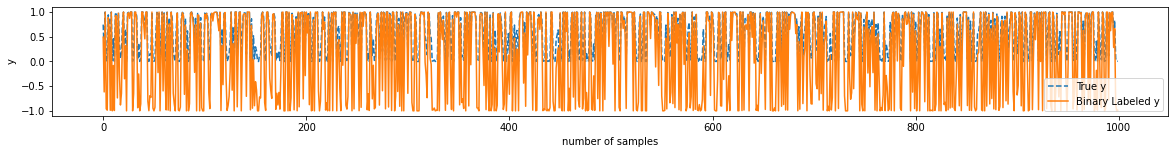

In [ ]:
# need to compact and generalize 
# need to revise the generalizing of W later, 1st, generate B, then add some bias on the edges of B to form W
# Generate bianry y {-1, 1}
torch.random.manual_seed(4)
nv = [3, 3, 3]
ns = 1000
v = [[],[],[]]
z = v
for i in np.arange(len(nv)):
  v[i] = torch.randn(ns,nv[i])
  z[i] = torch.hstack((v[i], torch.ones([ns,1])))
X = np.einsum('hi,hj,hk -> hijk',v[0], v[1], v[2])
# print(np.shape(X)) # (100, 3, 3, 3)
Z = np.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2]) 
print(np.shape(Z)) # (100, 4, 4, 4)
W = torch.normal(0, 1, size=(4, 4, 4)).numpy()
# W = random_cp((4,4,4), rank=3, random_state=1234, full=False)
# y = np.einsum('hijk, ijk -> h', Z, W) 
y = 1/(1+ np.exp(-np.einsum('hijk, ijk -> h', Z, W)))
# print(y.size)
y_binary = 2*y - 1
t = np.arange(ns)
plt.figure(figsize=(20, 2))
plt.plot(t, y,'--', label='True y')
plt.plot(t, y_binary, label = 'Binary Labeled y')
plt.legend()
plt.xlabel('number of samples')
plt.ylabel('y')
# print(y_binary[0:5])
print(np.shape(z))
print(z[1].shape)

# CP decomposition on W

In [ ]:
# !pip install tensorly
import tensorly as tl
from tensorly.decomposition import CP, parafac, tucker
from tensorly import cp_to_tensor, tucker_to_tensor
from tensorly.random import random_cp

In [ ]:
from numpy.lib.function_base import diff
from numpy.core.einsumfunc import einsum
# from numpy.lib.function_base import diff
def Log_loss(y_hat, y):
  loss = np.log(1+np.exp(-np.dot(y,y_hat)))
  return loss
def diff_WZ_factors(z, factors, G, i):
  # print('***********************diff_WZ*******************************')
  n = len(factors) # n is the Tucker rank
  B = [[]] * n
  for m in range(n):
    # print('np.shape(z[%s]):'%m, np.shape(z[m]), 'shape(factors[%s])'%m, np.shape(factors[m]))
    B[m] = torch.einsum('ij,jk -> ik',z[m].double(), torch.from_numpy(factors[m]).double())
    # print('size of B[ %s ]' %m, np.shape(B[m])) #the size should be ns * R_m
  B_temp = B
  # print('type(B[0]):',type(B[0]),'\n, type(B):', type(B))
  # print(np.shape(B))
  B_temp.pop(i)
  # print('type(B_temp)',type(B_temp))
  # print(np.shape(B_temp[0])[0],'\n', np.shape(B_temp[1])[1])
  # print('shape(B_temp[0]:',np.shape(B_temp[0]),'\n', 'shape(B_temp[1]',np.shape(B_temp[1]))
  # bb = torch.einsum('ij,ik -> ijk',bb_list[0], bb_list[1]) # i is the number of samples
  # print('shape of z[i]:', np.shape(z[i]))
  bb = np.empty(shape=(np.shape(z[i])[0], np.shape(B_temp[0])[1], np.shape(B_temp[1])[1]))
  # print('np.shape(bb):\n',np.shape(bb))
  zbb  = np.empty(shape=(np.shape(z[i])[0], np.shape(z[i])[1],np.shape(B_temp[0])[1], np.shape(B_temp[1])[1])) #ns * 4*3*3
  if i == 0:
    differential_wz = np.empty(shape=(np.shape(z[i])[0],np.shape(z[i])[1],np.shape(factors[i])[1]))
    bb = torch.einsum('ik,il->ikl',B_temp[0], B_temp[1])
    zbb = torch.einsum('ij, ikl ->ijkl', z[i],bb)
    # print('np.type(zbb):' ,type(zbb), '\n type of G:', type(G))
    # G = torch.from_numpy(G)
    differential_wz =  torch.einsum('ijkl,mkl->ijm',zbb.float(), G.float())
  elif i == 1:
    differential_wz = np.empty(shape=(np.shape(z[i])[0],np.shape(z[i])[1],np.shape(factors[i])[1]))
    bb = torch.einsum('ik,il->ikl',B_temp[0], B_temp[1])
    zbb = torch.einsum('ij, ikl ->ijkl', z[i],bb)
    # print('np.type(zbb):' ,type(zbb), '\n type of G:', type(G))
    # G = torch.from_numpy(G)
    differential_wz =  torch.einsum('ijkl,mkl->ijm',zbb.float(), G.float())
  elif i == 2:
    differential_wz = np.empty(shape=(np.shape(z[i])[0],np.shape(z[i])[1],np.shape(factors[i])[1]))
    bb = torch.einsum('ik,il->ikl',B_temp[0], B_temp[1])
    zbb = torch.einsum('ij, ikl ->ijkl', z[i],bb)
    # print('np.type(zbb):' ,type(zbb), '\n type of G:', type(G))
    # G = torch.from_numpy(G)
    differential_wz =  torch.einsum('ijkl,mkl->ijm',zbb.float(), G.float())
  # print('type of diff_WZ',type(differential_wz)) 
  # print('********************shape of diff_WZ:', np.shape(differential_wz))
  return differential_wz

 # the differential of Loss over the core tensor G
def diff_wz_G(z, factors): 
  # print('***********************diff_loss_G*******************************')
  Z = torch.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2])
  # print('******diff_loss_G**********')
  # print('np.shape(Z):',np.shape(Z))
  # differential = np.empty(shape=(len(z), np.shape(factors[0])[1], np.shape(factors[1])[1], np.shape(factors[2])[1]))
  differential = torch.einsum('ab,cd,ef,iace->ibdf',torch.from_numpy(factors[0]).float(), torch.from_numpy(factors[1]).float(), torch.from_numpy(factors[2]).float(), Z)
  # print('type(differential)',type(differential))
  # print('*********************shape of diff_wz_G',np.shape(differential))
  # print('differentialG:', differential)
  return differential
def diff_loss_G(y, y_hat, z, factors):
  diff_wz_g = diff_wz_G(z=z, factors=factors)
  # print('shape of diff_wz_g:', np.shape(diff_wz_g))
  differential = -torch.einsum('i, ijkp->jkp', torch.from_numpy(y), diff_wz_g)/(1+ np.exp(np.dot(y,y_hat)))
  return differential
def diff_loss_factor(y, y_hat, z, factors, G, i): #i here denotes the ith number of factor; B is a list of b_i # 三个factors貌似需要分开写
  # print('***************************diff_loss_factor*******************************')
  diff_wz = diff_WZ_factors(z=z,factors=factors, G=G, i=i)
  # differential = -torch.einsum('i, ijm->jm', y, diff_wz)/(1+ np.exp(np.dot(y,y_hat)))
  # ValueError: einstein sum subscripts string contains too many subscripts for operand 1
  differential = np.empty(shape=(len(y),np.shape(factors[i])[0],np.shape(factors[i])[1]))
  # print('type of diff_loss_factor',type(differential))
  for m in range(len(y)):
    differential[m] = -y[m]*diff_wz[m]/(1+ np.exp(np.dot(y,y_hat)))
  Z = torch.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2])
  W_hat = tl.tucker_to_tensor((G.numpy(), factors))
  W_hat = torch.from_numpy(W_hat)
  # print('***###tyep of W_hat and type of Z:',type(W_hat), type(Z))
  wz = torch.einsum('hijk, ijk -> h', Z.double(), W_hat)
  # diff_sigm = np.exp(-wz)/(np.dot(1+np.exp(-wz),1+np.exp(-wz)))
  # print(np.shape(y), np.shape(y_hat))
  # differential = -torch.einsum('i, ijk->jk', np.multiply(y, diff_sigm), diff_y)/(1+ np.exp(np.dot(y,y_hat)))
  differential = -torch.einsum('i, ijk->jk', torch.from_numpy(y), diff_wz)/(1+ np.exp(np.dot(y,y_hat)))
  # print('******************shape of differential_factors:', np.shape(differential))
  return differential

def train(z, factors, G, y, bs, epochs, lr, n):# n is the number of the order/dimenisonality of the tensor, also the number of views
# bs is the batchsize
  # sp = np.shape(z)#shape of z matrix; sp[0] denotes the Z tensor dimentionality/order\  
  # ns = sp[1]
  # #sp[1] denotes the number of samples; #sp[3]denotes the I_p, to simplify the experiment, all I_p is 4 here; (3+1), 3 is the number of features in each view
  ns = len(factors)
  losses_iter = []
  losses_epoch = []
  mse_epoch = []
  mse_iter = []
  for epoch in range(epochs):
    losses_b = []
    mse_b = []
    # iterate all samples in the following iterations
    for tt in range((ns-1)//bs + 1):
      start_tt = tt * bs
      end_tt = start_tt + bs
      yb = y[start_tt:end_tt]
      # print("z shape", np.shape(z), type(z))
      zb = [[]] * ns
      for i in range(ns):
        zb[i] = z[i][start_tt:end_tt,:]
        # print('\n zb[%s]'%i,zb[i])
      Z = torch.einsum('ni,nj,nk -> nijk', zb[0],zb[1],zb[2])
      # print(type(factors))
      # print('type of G and type of factors',type(G),type(factors[0]))
      # print('shape of G and factors',np.shape(G), np.shape(factors[0]),np.shape(factors[1]), np.shape(factors[2]))
      W_hat = tl.tucker_to_tensor((G.numpy(), factors))
      # print('shape of W_hat',np.shape(W_hat))
      W_hat = torch.from_numpy(W_hat)
      # print('Z:\n', Z, '\n W_hat:', W_hat)
      # print('type of W_hat and type of Z:',type(W_hat), type(Z))
      # print('shape of W_hat and shape of Z:',np.shape(W_hat), np.shape(Z))
      temp_WZ = torch.einsum('ijk,nijk -> n', W_hat.float(), Z.float())
      # print('type of WZ',type(temp_WZ))
      y_hatb = 1/(1+torch.exp(-temp_WZ))
      if len(y_hatb) != len(yb):
        print('Error: len(y_hatb)!= len(yb)')
      for i in range(len(factors)):
        dA = diff_loss_factor(y=yb, y_hat=y_hatb, z=zb, factors=factors, G=G, i=i)/len(yb)
        dA = torch.mean(dA, 0, keepdim=True)
        # print('type(dA):',type(dA))
        # print('np.shape(dA):', np.shape(dA))
        # print('type(dA):',type(dA))
        factors[i] = factors[i] - lr * dA.numpy()
      dG = diff_loss_G(z=zb, factors=factors, y=yb, y_hat=y_hatb)/len(yb)
      # dG = torch.mean(dG, dim=0, keepdim=True)
      # dG = dG[0]
      # print('np.shape(dG)',np.shape(dG))
      # print('**************dG: ', dG,'**************')
      # print('G shape before iteration:',np.shape(G))
      # print('dG shape', np.shape(dG))
      G = G - lr * dG
      # print('G shape after iteration:',np.shape(G))
      mse = np.linalg.norm(W-W_hat.numpy())/np.size(W)
      l = Log_loss(y_hatb, yb)
      losses_b.append(l)
      mse_b.append(mse)
    losses_iter.extend(losses_b)
    losses_epoch.append(np.mean(losses_b))
    mse_iter.extend(mse_b)
    mse_epoch.append(np.mean(mse_b))
  return factors, G, losses_iter, losses_epoch, mse_epoch, mse_iter

In [ ]:
# fac_tucker = parafac(W, rank=3, n_iter_max=10, tol=1.0e-15, linesearch=False)
#initial factors:
init_factors = [np.random.randn(4,3), np.random.randn(4,3), np.random.randn(4,3)]
init_G = torch.randn((3,3,3))
type(init_G)

torch.Tensor

In [ ]:
bs =  64
epochs = 500
lr = 0.01
tucker_factors, G, Losses_ite, Losses_epoch, mse_epoch, mse_iter = train(z, factors=init_factors, G=init_G, y=y_binary, bs=bs, epochs=epochs, lr=lr, n=len(nv))
print(type(G))
'''
W_hat = tl.tucker_to_tensor((G, tucker_factors))
mse = tl.norm(W_hat-W)/np.size(W)
'''

<class 'torch.Tensor'>


'\nW_hat = tl.tucker_to_tensor((G, tucker_factors))\nmse = tl.norm(W_hat-W)/np.size(W)\n'

[0.39468677836890864, 0.345367298506865, 0.3049691693669848, 0.2718677054184112, 0.24464991480451545, 0.22214534304209724, 0.20341415827862738, 0.18770782893260798, 0.17443658699930872, 0.163135336119329, 0.15343698741376527, 0.14505182482660672, 0.13774958903974874, 0.13134641746002373, 0.12569466370821045, 0.12067534323492744, 0.1161911929099453, 0.1121633253937117, 0.10852644059464152, 0.10522659815126684, 0.10221845351120316, 0.09946478778332761, 0.09693335382605087, 0.0945973061838694, 0.09243374777310281, 0.09042246709400352, 0.08854630259561477, 0.08678941011581263, 0.0851369819260382, 0.08357339561148962, 0.08208082293597864, 0.08063446398600628, 0.07919722985452088, 0.07770797780211317, 0.07606553415924198, 0.07410726221957585, 0.0715952345511704, 0.06824513684324392, 0.06385617935980838, 0.0585321412868258, 0.05278940589197841, 0.04732032030344202, 0.042611926060416014, 0.03881132656283899, 0.035841781254230244, 0.03354751739253892, 0.031773648833579395, 0.030392815653064977,

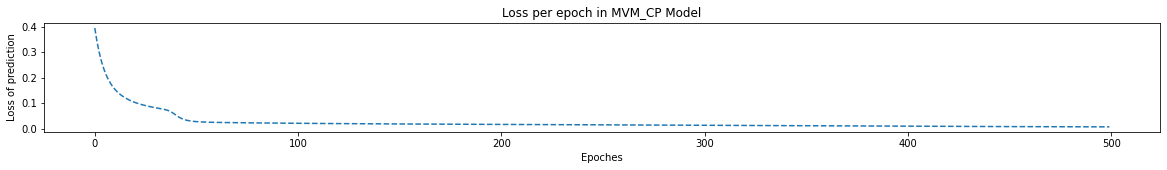

In [ ]:
plt.figure(figsize=(20, 2))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(Losses_epoch,'--', label='Losses per epoch')
plt.title('Loss per epoch in MVM_CP Model')
plt.xlabel('Epoches')
plt.ylabel('Loss of prediction')
print(Losses_epoch)

[0.39468677836890864, 0.345367298506865, 0.3049691693669848, 0.2718677054184112, 0.24464991480451545, 0.22214534304209724, 0.20341415827862738, 0.18770782893260798, 0.17443658699930872, 0.163135336119329, 0.15343698741376527, 0.14505182482660672, 0.13774958903974874, 0.13134641746002373, 0.12569466370821045, 0.12067534323492744, 0.1161911929099453, 0.1121633253937117, 0.10852644059464152, 0.10522659815126684, 0.10221845351120316, 0.09946478778332761, 0.09693335382605087, 0.0945973061838694, 0.09243374777310281, 0.09042246709400352, 0.08854630259561477, 0.08678941011581263, 0.0851369819260382, 0.08357339561148962, 0.08208082293597864, 0.08063446398600628, 0.07919722985452088, 0.07770797780211317, 0.07606553415924198, 0.07410726221957585, 0.0715952345511704, 0.06824513684324392, 0.06385617935980838, 0.0585321412868258, 0.05278940589197841, 0.04732032030344202, 0.042611926060416014, 0.03881132656283899, 0.035841781254230244, 0.03354751739253892, 0.031773648833579395, 0.030392815653064977,

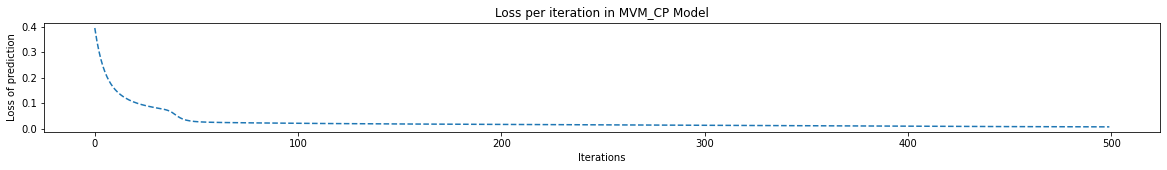

In [ ]:
plt.figure(figsize=(20, 2))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(Losses_ite,'--', label='Losses per iteration')
plt.title('Loss per iteration in MVM_CP Model')
plt.xlabel('Iterations')
plt.ylabel('Loss of prediction')
print(Losses_ite)

[0.48299069293186164, 0.4806097404254113, 0.4785670711277143, 0.47680094031899856, 0.47526070142610527, 0.4739055343802713, 0.4727028114346687, 0.47162651689462676, 0.47065592924737387, 0.46977440249506863, 0.4689686266224832, 0.46822777895403855, 0.46754308585837884, 0.46690730215785736, 0.46631447738457127, 0.46575964304268525, 0.4652386368761525, 0.4647479651194256, 0.46428461506040203, 0.4638460391260703, 0.46343004750740924, 0.4630347350684177, 0.462658451095447, 0.46229972643948314, 0.46195729348799847, 0.46163003423897814, 0.46131692776543126, 0.46101709421087445, 0.46072974276196305, 0.4604541674099494, 0.4601897131827715, 0.4599358580927368, 0.45969214658928786, 0.4594582693379616, 0.45923406370669256, 0.45901962551900366, 0.45881548173783787, 0.45862265467272495, 0.45844282029587075, 0.4582779633545461, 0.458129672913741, 0.457998198690205, 0.45788218049683566, 0.45777919288302227, 0.4576866710765668, 0.4576023326766283, 0.4575243539135351, 0.45745138597866064, 0.457382427266

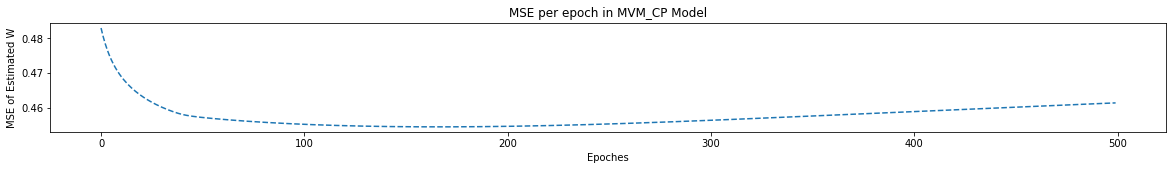

In [ ]:
plt.figure(figsize=(20, 2))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(mse_epoch,'--', label='mse per epoch')
plt.title('MSE per epoch in MVM_CP Model')
plt.xlabel('Epoches')
plt.ylabel('MSE of Estimated W')
print(mse_epoch)

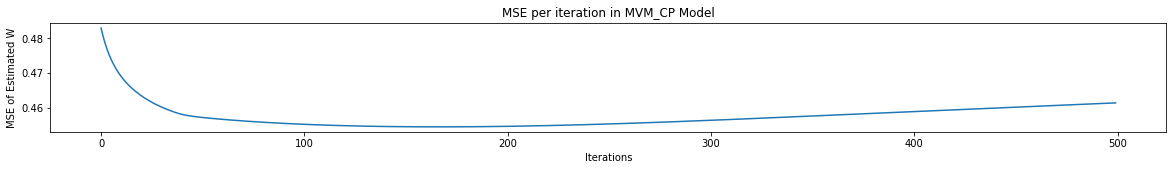

In [ ]:
plt.figure(figsize=(20, 2))
# plt.ylim([-(1e-8), 1e-8])
# plt.plot(Losses_epoch,'--', label='Losses per epoch')
plt.plot(mse_iter, label='Losses per iter')
plt.title('MSE per iteration in MVM_CP Model')
plt.xlabel('Iterations')
plt.ylabel('MSE of Estimated W')
print()

# Show confusion matrix of MVM_CP 
## reference paper: Multi-view Machines

In [ ]:
# import seaborn as sns
# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

# ax.set_title('Seaborn Confusion Matrix with labels\n\n');
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');
# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['-1: False','+1: True'])
# ax.yaxis.set_ticklabels(['-1: False','+1: True'])
# plt.title('Confusion Matrix via CP MVM')
# ## Display the visualization of the Confusion Matrix.
# plt.show()

# MVM via Tucker
## Reference paper: CARMAR

In [ ]:
# from numpy.lib.function_base import diff
def Log_loss(y_hat, y):
  loss = np.log(1+np.exp(-np.dot(y,y_hat)))
  return loss
def diff_loss(y, y_hat, z, B, factors, i): #i denotes that the differential is over the ith factor A^(i)
  bb_torch = np.concatenate([B[0:i,:,:], B[i+1:,:,:]], axis=0)
  bb_torch = torch.from_numpy(bb_torch)
  bb = torch.einsum('ij,ij -> ij',bb_torch[0,:,:], bb_torch[1,:,:]) # need be revised into a for-iteration form when generalizing #ns *3
  diff_y =  torch.einsum('ij,ik -> ijk', z[i], bb) #
  # print(np.shape(diff_y))
  # print(np.shape(y))
  differential = -torch.einsum('i, ijk->jk', y, diff_y)/(1+ np.exp(np.dot(y,y_hat)))
  Z = torch.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2])
  wz = torch.einsum('hijk, ijk -> h', Z, W)
  diff_sigm = np.exp(-wz)/(np.dot(1+np.exp(-wz),1+np.exp(-wz)))
  # print(np.shape(y), np.shape(y_hat))
  # differential = -torch.einsum('i, ijk->jk', np.multiply(y, diff_sigm), diff_y)/(1+ np.exp(np.dot(y,y_hat)))
  # differential = -torch.einsum('i, ijk->jk', y, diff_y)/(1+ np.exp(np.dot(y,y_hat)))
  return differential
def train(z, factors, y, bs, epochs, lr, n):# n is the number of the order/dimenisonality of the tensor, also the number of views
  sp = np.shape(z)#shape of z matrix; sp[0] denotes the Z tensor dimentionality/order
  #sp[1] denotes the number of samples; #sp[3]denotes the I_p, to simplify the experiment, all I_p is 4 here; (3+1), 3 is the number of features in each view
  
  losses_iter = []
  losses_epoch = []
  ns = sp[1]
  z = np.array(z)
  for epoch in range(epochs):
    losses_b = []
    for tt in range((ns-1)//bs + 1):

      start_tt = tt * bs
      end_tt = start_tt + bs
      yb = y[start_tt:end_tt]
      zb = z[:,start_tt:end_tt,:]
      temp = np.ones((len(yb), n))
      cp_rank = np.shape(factors[0])[1]
      Bb = np.empty((n,len(yb),cp_rank))
      for j in np.arange(n):
        Bb[j] = np.dot(zb[j], factors[j])      #shape(ns,k)
        temp = np.multiply(temp, Bb[j])
      y_hatb = np.sum(temp, axis=1)
      if len(y_hatb) != len(yb):
        print('Error: len(y_hat)!= len(y)')
      for i in range(len(factors)):
        dA = diff_loss(y=yb, y_hat=y_hatb, z=zb, B=Bb, factors=factors, i=i)
        # print(dA)
        factors[i] = factors[i] - lr * dA
      l = Log_loss(y_hatb, yb)
      losses_b.append(l)
    losses_iter.extend(losses_b)
    losses_epoch.append(np.mean(losses_b))
  return factors, losses_iter, losses_epoch
 

In [ ]:
# import seaborn as sns
# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

# ax.set_title('Seaborn Confusion Matrix with labels\n\n');
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');
# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['-1: False','+1: True'])
# ax.yaxis.set_ticklabels(['-1: False','+1: True'])
# plt.title('Confusion Matrix via Tucker MVM')
# ## Display the visualization of the Confusion Matrix.
# plt.show()